# Задание 6: Рекуррентные нейронные сети (RNNs)

Это задание адаптиповано из Deep NLP Course at ABBYY (https://github.com/DanAnastasyev/DeepNLP-Course) с разрешения автора - Даниила Анастасьева. Спасибо ему огромное!

In [1]:
# !pip3 -qq install torch==0.4.1
# !pip3 -qq install bokeh==0.13.0
# !pip3 -qq install gensim==3.6.0
# !pip3 -qq install nltk
# !pip3 -qq install scikit-learn==0.20.2

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

# Рекуррентные нейронные сети (RNNs)

## POS Tagging

Мы рассмотрим применение рекуррентных сетей к задаче sequence labeling (последняя картинка).

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [3]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


Пример размеченного предложения:

In [4]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [5]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


Построим маппинги из слов в индекс и из тега в индекс:


In [6]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'ADP', 'ADV', 'DET', 'NUM', 'CONJ', 'PRON', 'VERB', 'X', 'PRT', '.', 'ADJ', 'NOUN'}


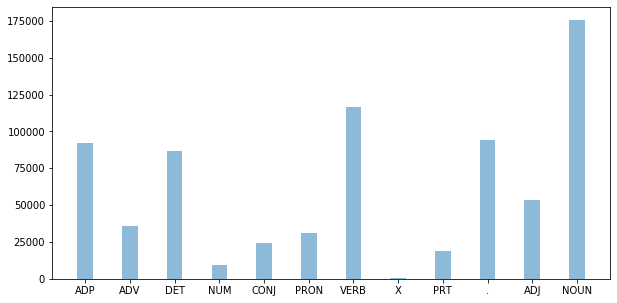

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png)  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

In [8]:
# import nltk

default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

Accuracy of unigram tagger = 92.62%


Добавим вероятности переходов:

In [9]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

Accuracy of bigram tagger = 93.42%


Обратите внимание, что `backoff` важен:

In [10]:
trigram_tagger = nltk.TrigramTagger(train_data)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

Accuracy of trigram tagger = 23.33%


## Увеличиваем контекст с рекуррентными сетями

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:  
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [11]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [12]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start:end]
        
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [13]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))
# shape changes from batch to batch!
X_batch.shape, y_batch.shape

((32, 4), (32, 4))

**Задание** Реализуйте `LSTMTagger`:

In [14]:
from torch.autograd import Variable

In [15]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super(LSTMTagger, self).__init__()
        self.tagset_size = tagset_size
        self.hidden_dim = lstm_hidden_dim
        self.num_layers = lstm_layers_count
        
        self.word_embeddings = nn.Embedding(vocab_size, word_emb_dim)
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_count)
        self.hidden2tag = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        seq_len, batch_size = inputs.size() # shape is (seq, batch)
        # Reset, otherwise the LSTM will treat a new batch as a continuation of a sequence
        self.hidden = self.init_hidden(batch_size)
        
        embeds = self.word_embeddings(inputs) # shape is (seq, batch, emb)
        
        # (seq, batch, emb) -> (seq, batch, hidden_dim)
#         lstm_out, _ = self.lstm(embeds) 
#         lstm_out, _ = self.lstm(embeds.view(seq_len, batch_size, -1)) # why do we need view?
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        
        # (seq, batch, hidden_dim) -> (seq * batch, hidden_dim)
        tag_space = self.hidden2tag(lstm_out.view(seq_len * batch_size, self.hidden_dim))

#         tag_scores = F.log_softmax(tag_space, dim=1)
        # (seq * batch, hidden_dim) -> (seq, batch, tagset_size)
#         tag_scores = tag_scores.view(seq_len, batch_size, self.tagset_size)
        
        tag_scores = tag_space.view(seq_len, batch_size, self.tagset_size)
        
        return tag_scores
    
    def init_hidden(self, batch_size):
        hidden = Variable(next(self.parameters()).data.new(self.num_layers, batch_size, self.hidden_dim))
        cell = Variable(next(self.parameters()).data.new(self.num_layers, batch_size, self.hidden_dim))
        
        return hidden.zero_(), cell.zero_()

**Задание** Научитесь считать accuracy и loss (а заодно проверьте, что модель работает)

In [16]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)

In [21]:
def compute_accuracy_counts(predictions, correct_tag_indices):
    _, indices = torch.max(predictions, 2) # (seq, batch, tagset_size) -> (seq, batch)
    seq, batch_size = correct_tag_indices.shape
#     pad_mask = torch.where(correct_tag_indices != 0, torch.ones(seq, batch_size), torch.zeros(seq, batch_size))
    pad_mask = correct_tag_indices != 0.0 
    sum_count = torch.sum(pad_mask)
    correct_count = torch.sum((indices == correct_tag_indices) * pad_mask)
    
    return correct_count.type(FloatTensor), sum_count.type(FloatTensor)

correct_tags_count, total_count = compute_accuracy_counts(logits, y_batch)
accuracy = correct_tags_count / total_count
print("Batch accuracy: %4.3f" % accuracy)

Batch accuracy: 0.087


In [22]:
criterion = nn.CrossEntropyLoss(ignore_index=0)

loss = criterion(logits.permute(1, 2, 0), y_batch.permute(1, 0))
print("Batch loss: %4.3f" % loss)

Batch loss: 2.560


**Задание** Вставьте эти вычисление в функцию:

In [35]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                logits = model(X_batch)

                loss = criterion(logits.permute(1, 2, 0), y_batch.permute(1, 0))

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                cur_correct_count, cur_sum_count = compute_accuracy_counts(logits, y_batch)

                correct_count += cur_correct_count
                sum_count += cur_sum_count
                
                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')
        
        # prevent overfitting
        if train_acc > 0.9999:
            return

In [26]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.67754, Accuracy = 78.53%: 100%|████████████████████████████| 572/572 [00:05<00:00, 101.18it/s]
[1 / 50]   Val: Loss = 0.35620, Accuracy = 87.89%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 82.16it/s]
[2 / 50] Train: Loss = 0.27100, Accuracy = 91.02%: 100%|████████████████████████████| 572/572 [00:05<00:00, 100.74it/s]
[2 / 50]   Val: Loss = 0.25475, Accuracy = 91.32%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 80.65it/s]
[3 / 50] Train: Loss = 0.18468, Accuracy = 93.87%: 100%|████████████████████████████| 572/572 [00:05<00:00, 100.73it/s]
[3 / 50]   Val: Loss = 0.20937, Accuracy = 92.80%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 81.14it/s]
[4 / 50] Train: Loss = 0.13855, Accuracy = 95.37%: 100%|████████████████████████████| 572/572 [00:05<00:00, 101.52it/s]
[4 / 50]   Val: Loss = 0.18520, Accuracy = 93.59%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 82.68it/s]
[5 / 50] Train: Loss = 0.10827, Accuracy

[35 / 50] Train: Loss = 0.00465, Accuracy = 99.82%: 100%|███████████████████████████| 572/572 [00:05<00:00, 104.72it/s]
[35 / 50]   Val: Loss = 0.41905, Accuracy = 94.18%: 100%|██████████████████████████████| 13/13 [00:00<00:00, 86.22it/s]
[36 / 50] Train: Loss = 0.00399, Accuracy = 99.84%: 100%|███████████████████████████| 572/572 [00:05<00:00, 104.60it/s]
[36 / 50]   Val: Loss = 0.43066, Accuracy = 94.23%: 100%|██████████████████████████████| 13/13 [00:00<00:00, 89.15it/s]
[37 / 50] Train: Loss = 0.00396, Accuracy = 99.84%: 100%|███████████████████████████| 572/572 [00:05<00:00, 104.70it/s]
[37 / 50]   Val: Loss = 0.43761, Accuracy = 94.15%: 100%|██████████████████████████████| 13/13 [00:00<00:00, 87.38it/s]
[38 / 50] Train: Loss = 0.00394, Accuracy = 99.85%: 100%|███████████████████████████| 572/572 [00:05<00:00, 104.30it/s]
[38 / 50]   Val: Loss = 0.45582, Accuracy = 94.08%: 100%|██████████████████████████████| 13/13 [00:00<00:00, 85.93it/s]
[39 / 50] Train: Loss = 0.00390, Accurac

### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

**Задание** Посчитайте качество модели на тесте. Ожидается результат лучше бейзлайна!

In [27]:
do_epoch(model, criterion, data=(X_test, y_test), batch_size=512)

      Loss = 0.44650, Accuracy = 94.30%: 100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 76.29it/s]


(0.44649648134197506, tensor(0.9430, device='cuda:0'))

### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png)  
*From [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)*

**Задание** Добавьте Bidirectional LSTM.

In [28]:
class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super(BiLSTMTagger, self).__init__()
        self.tagset_size = tagset_size
        self.hidden_dim = lstm_hidden_dim
        self.num_layers = lstm_layers_count
        
        self.word_embeddings = nn.Embedding(vocab_size, word_emb_dim)
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim // 2, lstm_layers_count, bidirectional=True)
        self.hidden2tag = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        seq_len, batch_size = inputs.size() # shape is (seq, batch)
        
        # Reset, otherwise the LSTM will treat a new batch as a continuation of a sequence
        self.hidden = self.init_hidden(batch_size)
        
        embeds = self.word_embeddings(inputs) # shape is (seq, batch, emb)
        
        lstm_out, self.hidden = self.lstm(embeds, self.hidden) # (seq, batch, emb) -> (seq, batch, hidden_dim)
        
        # (seq, batch, hidden_dim) -> (seq * batch, hidden_dim)
        tag_space = self.hidden2tag(lstm_out.view(seq_len * batch_size, -1)) 

#         tag_scores = F.log_softmax(tag_space, dim=1)
        # (seq * batch, hidden_dim) -> (seq, batch, tagset_size)
#         tag_scores = tag_scores.view(seq_len, batch_size, self.tagset_size)
        
        tag_scores = tag_space.view(seq_len, batch_size, self.tagset_size)
        
        return tag_scores
    
    def init_hidden(self, batch_size):
        hidden = Variable(next(self.parameters()).data.new(2 * self.num_layers, batch_size, self.hidden_dim // 2))
        cell = Variable(next(self.parameters()).data.new(2 * self.num_layers, batch_size, self.hidden_dim // 2))
        
        return hidden.zero_(), cell.zero_()

In [36]:
torch.cuda.empty_cache()
model = BiLSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=35,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 35] Train: Loss = 0.63266, Accuracy = 80.41%: 100%|█████████████████████████████| 572/572 [00:06<00:00, 86.05it/s]
[1 / 35]   Val: Loss = 0.29710, Accuracy = 90.51%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 79.92it/s]
[2 / 35] Train: Loss = 0.21840, Accuracy = 93.11%: 100%|█████████████████████████████| 572/572 [00:06<00:00, 86.44it/s]
[2 / 35]   Val: Loss = 0.19340, Accuracy = 93.96%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 83.47it/s]
[3 / 35] Train: Loss = 0.14055, Accuracy = 95.65%: 100%|█████████████████████████████| 572/572 [00:06<00:00, 85.75it/s]
[3 / 35]   Val: Loss = 0.15228, Accuracy = 95.24%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 87.95it/s]
[4 / 35] Train: Loss = 0.09949, Accuracy = 96.97%: 100%|█████████████████████████████| 572/572 [00:06<00:00, 87.75it/s]
[4 / 35]   Val: Loss = 0.13355, Accuracy = 95.79%: 100%|███████████████████████████████| 13/13 [00:00<00:00, 91.02it/s]
[5 / 35] Train: Loss = 0.07309, Accuracy

### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [37]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


Построим подматрицу для слов из нашей тренировочной выборки:

In [38]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 38736 out of 45441 word embeddings


**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [43]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super(LSTMTaggerWithPretrainedEmbs, self).__init__()
        self.tagset_size = tagset_size
        self.hidden_dim = lstm_hidden_dim
        self.num_layers = lstm_layers_count
        # unfreeze the training so that zero embeddings will be different after training (if there are any)
        self.word_embeddings = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.lstm = nn.LSTM(embeddings.shape[1], lstm_hidden_dim // 2, lstm_layers_count, bidirectional=True)
        self.hidden2tag = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        seq_len, batch_size = inputs.size() # shape is (seq, batch)
        
        # Reset, otherwise the LSTM will treat a new batch as a continuation of a sequence
        self.hidden = self.init_hidden(batch_size)
        
        embeds = self.word_embeddings(inputs) # shape is (seq, batch, emb)
        
        lstm_out, self.hidden = self.lstm(embeds, self.hidden) # (seq, batch, emb) -> (seq, batch, hidden_dim)
        
        # (seq, batch, hidden_dim) -> (seq * batch, hidden_dim)
        tag_space = self.hidden2tag(lstm_out.view(seq_len * batch_size, -1)) 

#         tag_scores = F.log_softmax(tag_space, dim=1)
        # (seq * batch, hidden_dim) -> (seq, batch, tagset_size)
#         tag_scores = tag_scores.view(seq_len, batch_size, self.tagset_size)
        
        tag_scores = tag_space.view(seq_len, batch_size, self.tagset_size)
        
        return tag_scores
    
    def init_hidden(self, batch_size):
        hidden = Variable(next(self.parameters()).data.new(2 * self.num_layers, batch_size, self.hidden_dim // 2))
        cell = Variable(next(self.parameters()).data.new(2 * self.num_layers, batch_size, self.hidden_dim // 2))
        
        return hidden.zero_(), cell.zero_()

In [44]:
model = LSTMTaggerWithPretrainedEmbs(
    embeddings=torch.tensor(embeddings).type(FloatTensor),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=35,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 35] Train: Loss = 0.50922, Accuracy = 86.31%: 100%|█████████████████████████████| 572/572 [00:06<00:00, 88.07it/s]
[1 / 35]   Val: Loss = 0.15229, Accuracy = 95.92%: 100%|██████████████████████████████| 13/13 [00:00<00:00, 112.02it/s]
[2 / 35] Train: Loss = 0.08681, Accuracy = 97.44%: 100%|█████████████████████████████| 572/572 [00:06<00:00, 88.44it/s]
[2 / 35]   Val: Loss = 0.11457, Accuracy = 96.90%: 100%|██████████████████████████████| 13/13 [00:00<00:00, 110.59it/s]
[3 / 35] Train: Loss = 0.05528, Accuracy = 98.29%: 100%|█████████████████████████████| 572/572 [00:06<00:00, 88.19it/s]
[3 / 35]   Val: Loss = 0.09988, Accuracy = 97.23%: 100%|██████████████████████████████| 13/13 [00:00<00:00, 111.06it/s]
[4 / 35] Train: Loss = 0.04065, Accuracy = 98.73%: 100%|█████████████████████████████| 572/572 [00:06<00:00, 90.23it/s]
[4 / 35]   Val: Loss = 0.09194, Accuracy = 97.29%: 100%|██████████████████████████████| 13/13 [00:00<00:00, 117.01it/s]
[5 / 35] Train: Loss = 0.03200, Accuracy

**Задание** Оцените качество модели на тестовой выборке. Обратите внимание, вовсе не обязательно ограничиваться векторами из урезанной матрицы - вполне могут найтись слова в тесте, которых не было в трейне и для которых есть эмбеддинги.

Добейтесь качества лучше прошлых моделей.

In [45]:
do_epoch(model, criterion, data=(X_test, y_test), batch_size=512)

      Loss = 0.24434, Accuracy = 96.22%: 100%|████████████████████████████████████████| 28/28 [00:00<00:00, 102.27it/s]


(0.24434445479086467, tensor(0.9622, device='cuda:0'))

In [ ]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super(LSTMTaggerWithPretrainedEmbs, self).__init__()
        self.tagset_size = tagset_size
        self.hidden_dim = lstm_hidden_dim
        self.num_layers = lstm_layers_count
        
        self.word_embeddings = nn.Embedding.from_pretrained(embeddings)
        self.lstm = nn.LSTM(embeddings.shape[1], lstm_hidden_dim, lstm_layers_count)
        self.hidden2tag = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        seq_len, batch_size = inputs.size() # shape is (seq, batch)
        embeds = torch.where(inputs in w2v_model.vocab, w2v_model.get_vector(inputs),\
                             Variable(next(self.word_embeddings.parameters()).data\
                                      .new(self.word_embeddings.shape[0])).zero_())
        # Reset, otherwise the LSTM will treat a new batch as a continuation of a sequence
#         self.hidden = self.init_hidden(batch_size) 
        embeds = self.word_embeddings(inputs) # shape is (seq, batch, emb)
        lstm_out, _ = self.lstm(embeds) # (seq, batch, emb) -> (seq, batch, hidden_dim)
#         lstm_out, _ = self.lstm(embeds.view(seq_len, batch_size, -1)) # why do we need view?
#         lstm_out, self.hidden = self.lstm(embeds.view(seq_len, batch_size, -1), self.hidden)
        # (seq, batch, hidden_dim) -> (seq * batch, hidden_dim)
        tag_space = self.hidden2tag(lstm_out.view(seq_len * batch_size, -1)) 
#         tag_space = self.hidden2tag(lstm_out.view(seq_len, -1))

#         tag_scores = F.log_softmax(tag_space, dim=1)
        # (seq * batch, hidden_dim) -> (seq, batch, tagset_size)
#         tag_scores = tag_scores.view(seq_len, batch_size, self.tagset_size)
        
        tag_scores = tag_space.view(seq_len, batch_size, self.tagset_size)
        
        return tag_scores
    
#     def init_hidden(self, batch_size):
#         hidden = Variable(next(self.parameters()).data.new(2 * self.num_layers, batch_size, self.hidden_dim // 2))
#         cell = Variable(next(self.parameters()).data.new(2 * self.num_layers, batch_size, self.hidden_dim // 2))
        
#         return hidden.zero_(), cell.zero_()

In [ ]:
model = LSTMTaggerWithPretrainedEmbs(
    embeddings=embeddings,
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(train_data, y_train), epochs_count=35,
    batch_size=64, val_data=(val_data, y_val), val_batch_size=512)

In [ ]:
do_epoch(model, criterion, data=(test_data, y_test), batch_size=512)